In [3]:
import pandas as pd
import geopandas as gpd
import osmnx as osm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyproj import Transformer
from shapely.geometry import *
import networkx as nx
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from cdlib import algorithms, viz, evaluation
import numpy as np

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'infomap', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [63]:
# import all the data
trip_data = pd.read_csv('../Data/02_Processed_Data/cleaned_trip_data.csv')
trip_data['Start date'] = pd.to_datetime(trip_data['Start date'])
trip_data['End date'] = pd.to_datetime(trip_data['End date'])
station_data = pd.read_csv('../Data/02_Processed_Data/Station_data_with_community.csv')
station_data = gpd.GeoDataFrame(station_data, geometry=gpd.points_from_xy(station_data['lon'], station_data['lat'], crs='epsg:4326'))
station_data = osm.project_gdf(station_data)
central_london = osm.io.load_graphml('../Data/02_Processed_Data/Central_london.osm')

# Peak Usage Analysis

In [64]:
usage_data = trip_data.copy()

number_of_days = usage_data['Start date'].dt.date.nunique()

usage_data['Start date'] = usage_data['Start date'].dt.floor('H')
usage_data['End date'] = usage_data['End date'].dt.floor('H')

usage_data_start = usage_data.groupby(['Start station', 'Start date']).size().reset_index(name='pick_up_demand')
usage_data_start = usage_data_start.rename(columns={'Start station': 'station', 'Start date': 'date'})

usage_data_end = usage_data.groupby(['End station', 'End date']).size().reset_index(name='drop_off_demand')
usage_data_end = usage_data_end.rename(columns={'End station': 'station', 'End date': 'date'})

usage_data = pd.merge(usage_data_start, usage_data_end, on=['station', 'date'], how='outer')
usage_data['Utilisation'] = usage_data['pick_up_demand'] + usage_data['drop_off_demand']
usage_data = usage_data.fillna(0)

In [65]:
usage_data_hourly = usage_data.copy()
usage_data_hourly['hour'] = usage_data_hourly['date'].dt.hour

usage_data_hourly = usage_data_hourly.groupby(['station', 'hour']).agg({'pick_up_demand': 'sum', 'drop_off_demand': 'sum', 'Utilisation': 'sum'}).reset_index()
usage_data_hourly

,station,hour,pick_up_demand,drop_off_demand,Utilisation
0,"Abbey Orchard Street, Westminster",0,5.0,3.0,3.0
1,"Abbey Orchard Street, Westminster",1,1.0,1.0,0.0
2,"Abbey Orchard Street, Westminster",2,2.0,5.0,2.0
3,"Abbey Orchard Street, Westminster",4,1.0,2.0,2.0
4,"Abbey Orchard Street, Westminster",5,2.0,2.0,4.0
...,...,...,...,...,...
8569,"Wren Street, Holborn",19,106.0,115.0,170.0
8570,"Wren Street, Holborn",20,63.0,95.0,108.0
8571,"Wren Street, Holborn",21,40.0,85.0,79.0
8572,"Wren Street, Holborn",22,15.0,71.0,23.0


In [66]:
# Adding the averages to the station data
usage_data_hourly_avg = usage_data_hourly.copy()
usage_data_hourly_avg['pick_up_demand_avg'] = usage_data_hourly_avg['pick_up_demand'] / number_of_days
usage_data_hourly_avg['drop_off_demand_avg'] = usage_data_hourly_avg['drop_off_demand'] / number_of_days
usage_data_hourly_avg['Utilisation_avg'] = usage_data_hourly_avg['Utilisation'] / number_of_days
usage_data_hourly_avg

,station,hour,pick_up_demand,drop_off_demand,Utilisation,pick_up_demand_avg,drop_off_demand_avg,Utilisation_avg
0,"Abbey Orchard Street, Westminster",0,5.0,3.0,3.0,0.076923,0.046154,0.046154
1,"Abbey Orchard Street, Westminster",1,1.0,1.0,0.0,0.015385,0.015385,0.000000
2,"Abbey Orchard Street, Westminster",2,2.0,5.0,2.0,0.030769,0.076923,0.030769
3,"Abbey Orchard Street, Westminster",4,1.0,2.0,2.0,0.015385,0.030769,0.030769
4,"Abbey Orchard Street, Westminster",5,2.0,2.0,4.0,0.030769,0.030769,0.061538
...,...,...,...,...,...,...,...,...
8569,"Wren Street, Holborn",19,106.0,115.0,170.0,1.630769,1.769231,2.615385
8570,"Wren Street, Holborn",20,63.0,95.0,108.0,0.969231,1.461538,1.661538
8571,"Wren Street, Holborn",21,40.0,85.0,79.0,0.615385,1.307692,1.215385
8572,"Wren Street, Holborn",22,15.0,71.0,23.0,0.230769,1.092308,0.353846


In [67]:
stations = station_data['commonName'].unique()
hours = range(24)

# Create a list to hold the new rows
new_rows = []

for station in stations:
    for hour in hours:
        if not ((usage_data_hourly_avg['station'] == station) & (usage_data_hourly_avg['hour'] == hour)).any():
            new_rows.append({
                'station': station, 
                'hour': hour, 
                'pick_up_demand': 0, 
                'drop_off_demand': 0, 
                'Utilisation': 0, 
                'pick_up_demand_avg': 0, 
                'drop_off_demand_avg': 0, 
                'Utilisation_avg': 0
            })

# Concatenate the original DataFrame with the new rows
if new_rows:
    usage_data_hourly_avg = pd.concat([usage_data_hourly_avg, pd.DataFrame(new_rows)], ignore_index=True)

# Sort the DataFrame
usage_data_hourly_avg = usage_data_hourly_avg.sort_values(by=['station', 'hour']).reset_index(drop=True)

usage_data_hourly_avg


,station,hour,pick_up_demand,drop_off_demand,Utilisation,pick_up_demand_avg,drop_off_demand_avg,Utilisation_avg
0,"Abbey Orchard Street, Westminster",0,5.0,3.0,3.0,0.076923,0.046154,0.046154
1,"Abbey Orchard Street, Westminster",1,1.0,1.0,0.0,0.015385,0.015385,0.000000
2,"Abbey Orchard Street, Westminster",2,2.0,5.0,2.0,0.030769,0.076923,0.030769
3,"Abbey Orchard Street, Westminster",3,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,"Abbey Orchard Street, Westminster",4,1.0,2.0,2.0,0.015385,0.030769,0.030769
...,...,...,...,...,...,...,...,...
8875,"Wren Street, Holborn",19,106.0,115.0,170.0,1.630769,1.769231,2.615385
8876,"Wren Street, Holborn",20,63.0,95.0,108.0,0.969231,1.461538,1.661538
8877,"Wren Street, Holborn",21,40.0,85.0,79.0,0.615385,1.307692,1.215385
8878,"Wren Street, Holborn",22,15.0,71.0,23.0,0.230769,1.092308,0.353846


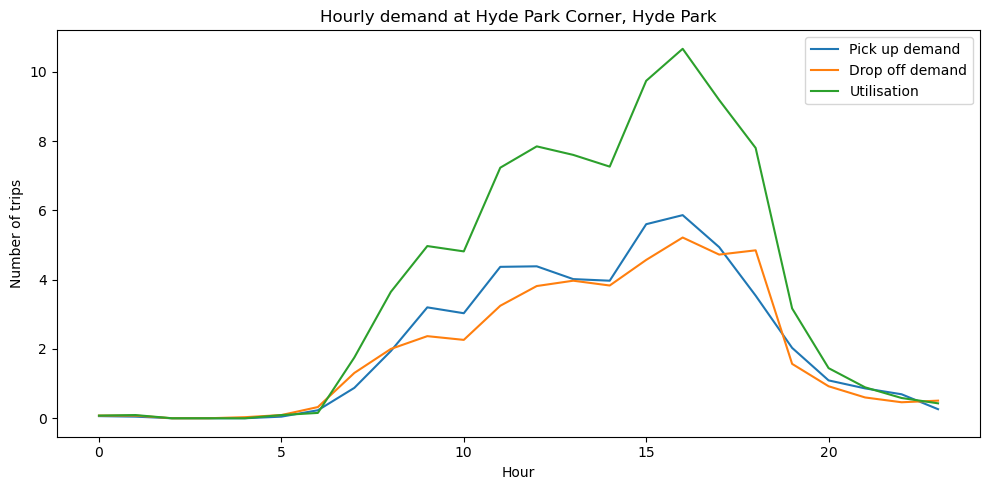

In [68]:
import matplotlib.pyplot as plt

station = 'Hyde Park Corner, Hyde Park'
data = usage_data_hourly_avg[usage_data_hourly_avg['station'] == station]

plt.figure(figsize=(10, 5))
plt.plot(data['hour'], data['pick_up_demand_avg'], label='Pick up demand')
plt.plot(data['hour'], data['drop_off_demand_avg'], label='Drop off demand')
plt.plot(data['hour'], data['Utilisation_avg'], label='Utilisation')

plt.title('Hourly demand at {}'.format(station))
plt.xlabel('Hour')
plt.ylabel('Number of trips')
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
# average over all the stations for the same hour
average_hourly_demand = usage_data_hourly_avg.groupby('hour').agg({'pick_up_demand_avg': 'mean', 'drop_off_demand_avg': 'mean', 'Utilisation_avg': 'mean'}).reset_index()
average_hourly_demand

,hour,pick_up_demand_avg,drop_off_demand_avg,Utilisation_avg
0,0,0.111310,0.135468,0.053015
1,1,0.058295,0.064699,0.022495
2,2,0.031684,0.036299,0.011601
3,3,0.025031,0.025281,0.007152
4,4,0.040748,0.036008,0.007900
5,5,0.094969,0.080873,0.019252
6,6,0.550520,0.449730,0.365738
7,7,1.551351,1.272391,1.749356
8,8,3.047526,2.857297,4.678420
9,9,1.697505,2.066778,2.825198


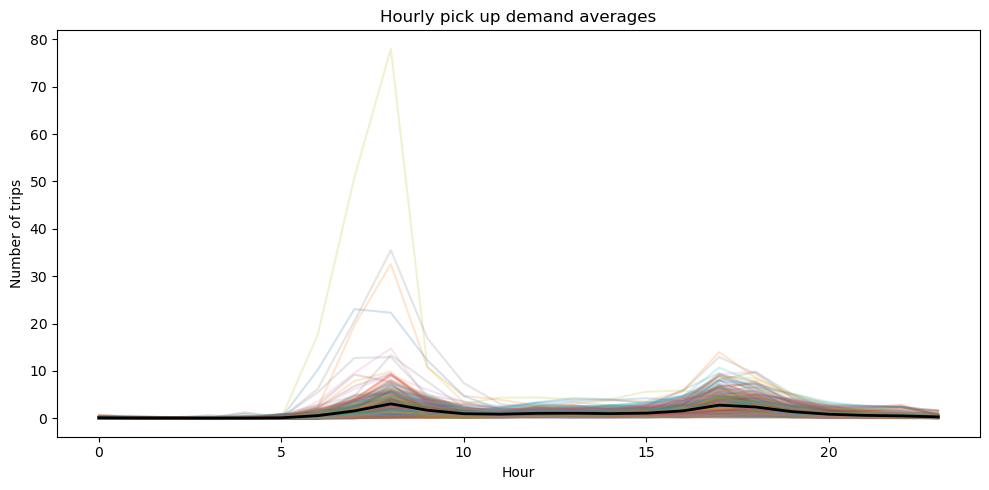

In [77]:
# plot all the pick up demand averages 
plt.figure(figsize=(10, 5))
for station in stations:
    data = usage_data_hourly_avg[usage_data_hourly_avg['station'] == station]
    plt.plot(data['hour'], data['pick_up_demand_avg'], label=station, alpha=0.2)
plt.plot(average_hourly_demand['hour'], average_hourly_demand['pick_up_demand_avg'], label='Average', color='black', linewidth=2)
plt.title('Hourly pick up demand averages')
plt.xlabel('Hour')
plt.ylabel('Number of trips')
#plt.legend()
plt.tight_layout()
plt.show()


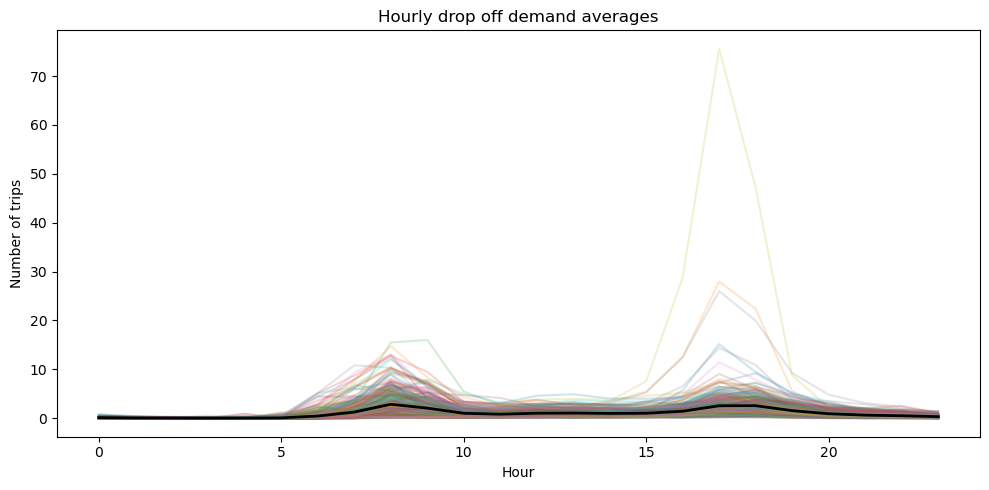

In [78]:
# plot all the drop off demand averages
plt.figure(figsize=(10, 5))
for station in stations:
    data = usage_data_hourly_avg[usage_data_hourly_avg['station'] == station]
    plt.plot(data['hour'], data['drop_off_demand_avg'], label=station, alpha=0.2)
plt.plot(average_hourly_demand['hour'], average_hourly_demand['drop_off_demand_avg'], label='Average', color='black', linewidth=2)
plt.title('Hourly drop off demand averages')
plt.xlabel('Hour')
plt.ylabel('Number of trips')
#plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# can you calculate a regression line for each station and then plot the residuals?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



In [ ]:
check_for_hours = usage_data_hourly_avg.groupby('station').size().reset_index(name='count')
check_for_hours

,station,count
0,"Abbey Orchard Street, Westminster",23
1,"Abingdon Green, Westminster",23
2,"Albany Street, The Regent's Park",24
3,"Albert Embankment, Vauxhall",24
4,"Albert Gate, Hyde Park",22
...,...,...
365,"Wood Street, Guildhall",20
366,"Woodstock Street, Mayfair",23
367,"Wormwood Street, Liverpool Street",24
368,"Worship Street, Shoreditch",22


In [ ]:

# Add 'Start hour' and 'Start date_only' columns
trip_data['Start hour'] = trip_data['Start date'].dt.hour
trip_data['Start date_only'] = trip_data['Start date'].dt.date

# Group by 'Start station', 'Start hour', and 'Start date_only' to count starting trips
start_trip_counts = trip_data.groupby(['Start station', 'Start hour', 'Start date_only']).size().reset_index(name='trip_count')

# Group by 'End station', 'Start hour', and 'Start date_only' to count ending trips
end_trip_counts = trip_data.groupby(['End station', 'Start hour', 'Start date_only']).size().reset_index(name='trip_count')

# Rename 'End station' column to 'Start station' in the end_trip_counts DataFrame for consistency
end_trip_counts.rename(columns={'End station': 'Start station'}, inplace=True)

# Combine the start and end trip counts into one DataFrame
combined_trip_counts = pd.concat([start_trip_counts, end_trip_counts])

# Group by station and hour again to calculate the median for combined trips
#  TODO!! AVG instead of median!!
median_trips_per_hour = combined_trip_counts.groupby(['Start station', 'Start hour'])['trip_count'].median().unstack().fillna(0)

# Reset index to have 'Start station' as a column again
median_trips_per_hour = median_trips_per_hour.reset_index()

# Merge with station data to include lat and lon
peak_data = median_trips_per_hour.merge(station_data[['commonName', 'lat', 'lon']], left_on='Start station', right_on='commonName')

# Drop unnecessary columns
peak_data.drop(columns=['commonName'], inplace=True)

peak_data


,Start station,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,lat,lon
0,"Abbey Orchard Street, Westminster",1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,...,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,51.498125,-0.132102
1,"Abingdon Green, Westminster",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.5,...,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,51.497640,-0.125972
2,"Albany Street, The Regent's Park",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,...,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,51.528302,-0.144466
3,"Albert Embankment, Vauxhall",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,51.490435,-0.122806
4,"Albert Gate, Hyde Park",3.0,1.5,0.0,0.0,1.0,1.0,1.0,1.0,2.0,...,4.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,51.502953,-0.158456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,"Wood Street, Guildhall",0.0,0.0,0.0,0.0,1.0,1.0,2.0,6.0,3.0,...,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,51.517008,-0.093885
366,"Woodstock Street, Mayfair",1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,51.514105,-0.147301
367,"Wormwood Street, Liverpool Street",1.0,1.0,1.0,1.0,1.0,1.0,6.0,13.0,12.0,...,7.0,15.0,10.0,3.0,2.0,1.0,1.0,1.0,51.516154,-0.082422
368,"Worship Street, Shoreditch",1.0,1.0,2.0,0.0,0.0,1.0,1.0,2.0,4.0,...,2.0,4.0,3.0,2.0,1.0,2.0,1.0,1.0,51.521668,-0.079608


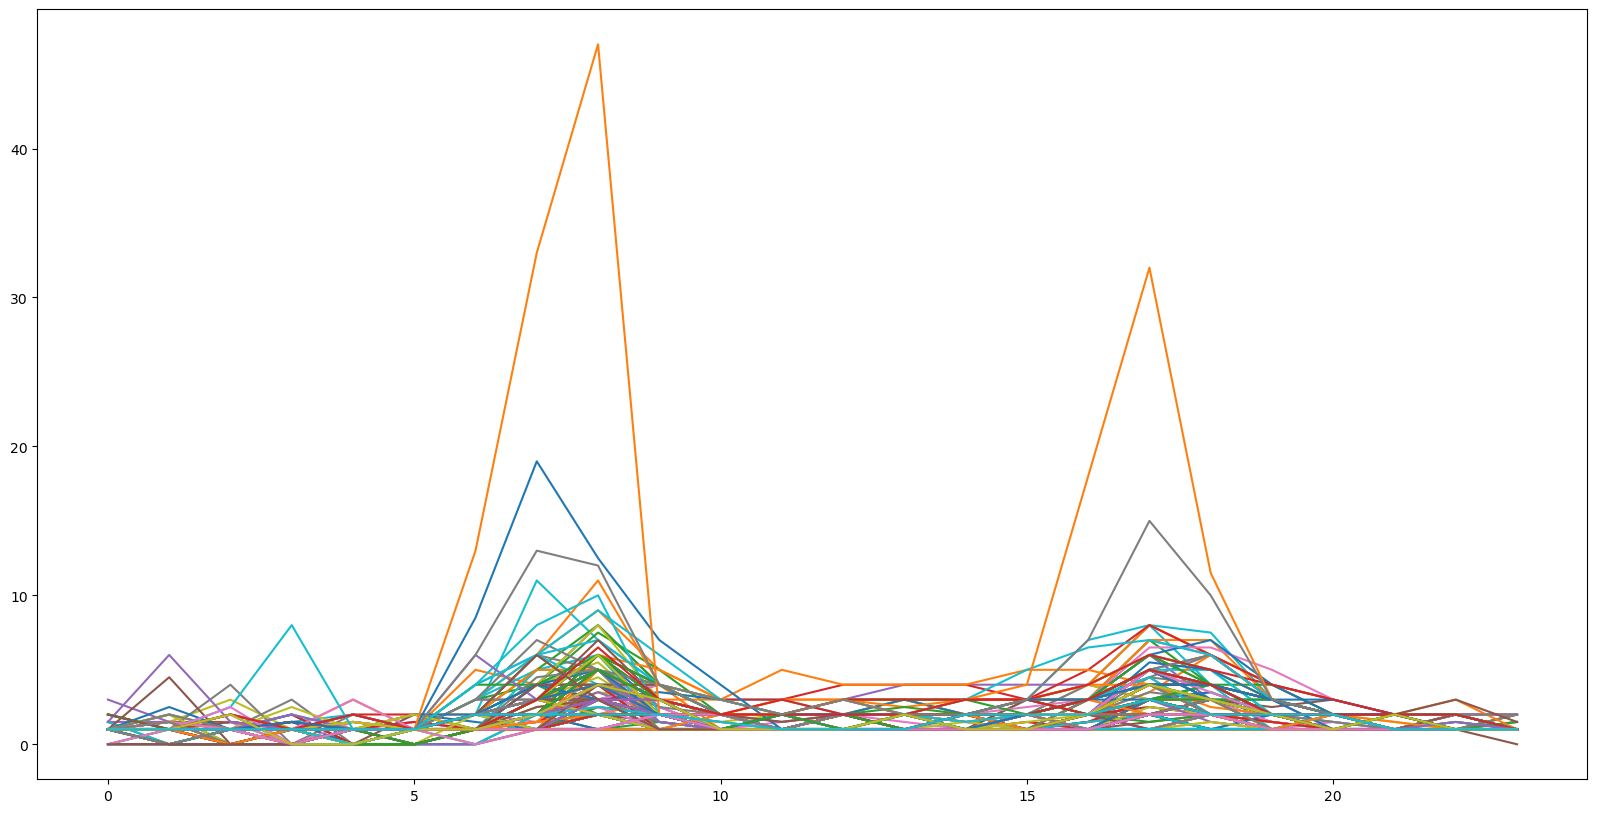

In [ ]:
# Plot the data, each station row is one time series 
fig, ax = plt.subplots(figsize=(20, 10))
for i, row in peak_data.iterrows():
    ax.plot(row.index[1:-2], row[1:-2], label=row['Start station'])
plt.show()


In [79]:
usage_data_hourly_avg.to_csv('../Data/03_Results/demand_and_utilisation.csv', index=False)

In [81]:
usage_data_hourly_avg

,station,hour,pick_up_demand,drop_off_demand,Utilisation,pick_up_demand_avg,drop_off_demand_avg,Utilisation_avg
0,"Abbey Orchard Street, Westminster",0,5.0,3.0,3.0,0.076923,0.046154,0.046154
1,"Abbey Orchard Street, Westminster",1,1.0,1.0,0.0,0.015385,0.015385,0.000000
2,"Abbey Orchard Street, Westminster",2,2.0,5.0,2.0,0.030769,0.076923,0.030769
3,"Abbey Orchard Street, Westminster",3,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,"Abbey Orchard Street, Westminster",4,1.0,2.0,2.0,0.015385,0.030769,0.030769
...,...,...,...,...,...,...,...,...
8875,"Wren Street, Holborn",19,106.0,115.0,170.0,1.630769,1.769231,2.615385
8876,"Wren Street, Holborn",20,63.0,95.0,108.0,0.969231,1.461538,1.661538
8877,"Wren Street, Holborn",21,40.0,85.0,79.0,0.615385,1.307692,1.215385
8878,"Wren Street, Holborn",22,15.0,71.0,23.0,0.230769,1.092308,0.353846


In [82]:
efficiency_data_set_erweitert = pd.read_csv('../Data/03_Results/efficiency_data_set_erweitert.csv')
final_data_set = pd.merge(efficiency_data_set_erweitert, usage_data_hourly_avg, how='left', left_on=['current_station', 'hour'], right_on=['station', 'hour'])
final_data_set

,current_station,hour,median_fullness_rate,station_x,factor,efficiency,fullness_based_on_x_observations,station_y,pick_up_demand,drop_off_demand,Utilisation,pick_up_demand_avg,drop_off_demand_avg,Utilisation_avg
0,"Abbey Orchard Street, Westminster",0,0.068966,"Abbey Orchard Street, Westminster",0.200000,0.131034,49,"Abbey Orchard Street, Westminster",5.0,3.0,3.0,0.076923,0.046154,0.046154
1,"Abbey Orchard Street, Westminster",1,0.068966,"Abbey Orchard Street, Westminster",0.200000,0.131034,50,"Abbey Orchard Street, Westminster",1.0,1.0,0.0,0.015385,0.015385,0.000000
2,"Abbey Orchard Street, Westminster",2,0.068966,"Abbey Orchard Street, Westminster",0.800000,0.731034,49,"Abbey Orchard Street, Westminster",2.0,5.0,2.0,0.030769,0.076923,0.030769
3,"Abbey Orchard Street, Westminster",3,0.068966,"Abbey Orchard Street, Westminster",0.500000,0.431034,47,"Abbey Orchard Street, Westminster",0.0,0.0,0.0,0.000000,0.000000,0.000000
4,"Abbey Orchard Street, Westminster",4,0.068966,"Abbey Orchard Street, Westminster",0.200000,0.131034,47,"Abbey Orchard Street, Westminster",1.0,2.0,2.0,0.015385,0.030769,0.030769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,"York Way, Kings Cross",19,0.208333,"York Way, Kings Cross",0.560000,0.351667,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19100,"York Way, Kings Cross",20,0.250000,"York Way, Kings Cross",0.646154,0.396154,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19101,"York Way, Kings Cross",21,0.291667,"York Way, Kings Cross",0.650000,0.358333,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19102,"York Way, Kings Cross",22,0.333333,"York Way, Kings Cross",0.542857,0.209524,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
final_data_set.drop(columns=['station_y', 'station_x'], inplace=True)
final_data_set.rename(columns={'current_station': 'station', 'factor': 'target_fullness', 'efficiency': 'fullness_deviation', 'pick_up_demand': 'pick_up_demand_sum_over_3_months', 'drop_off_demand': 'drop_off_demand_sum_over_3_months', 'Utilisation': 'utilisation_over_3_months'}, inplace=True)
final_data_set

,station,hour,median_fullness_rate,target_fullness,fullness_deviation,fullness_based_on_x_observations,pick_up_demand_sum_over_3_months,drop_off_demand_sum_over_3_months,utilisation_over_3_months,pick_up_demand_avg,drop_off_demand_avg,Utilisation_avg
0,"Abbey Orchard Street, Westminster",0,0.068966,0.200000,0.131034,49,5.0,3.0,3.0,0.076923,0.046154,0.046154
1,"Abbey Orchard Street, Westminster",1,0.068966,0.200000,0.131034,50,1.0,1.0,0.0,0.015385,0.015385,0.000000
2,"Abbey Orchard Street, Westminster",2,0.068966,0.800000,0.731034,49,2.0,5.0,2.0,0.030769,0.076923,0.030769
3,"Abbey Orchard Street, Westminster",3,0.068966,0.500000,0.431034,47,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,"Abbey Orchard Street, Westminster",4,0.068966,0.200000,0.131034,47,1.0,2.0,2.0,0.015385,0.030769,0.030769
...,...,...,...,...,...,...,...,...,...,...,...,...
19099,"York Way, Kings Cross",19,0.208333,0.560000,0.351667,115,NaN,NaN,NaN,NaN,NaN,NaN
19100,"York Way, Kings Cross",20,0.250000,0.646154,0.396154,120,NaN,NaN,NaN,NaN,NaN,NaN
19101,"York Way, Kings Cross",21,0.291667,0.650000,0.358333,120,NaN,NaN,NaN,NaN,NaN,NaN
19102,"York Way, Kings Cross",22,0.333333,0.542857,0.209524,122,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
final_data_set_central_london = final_data_set.dropna()
final_data_set_central_london

,station,hour,median_fullness_rate,target_fullness,fullness_deviation,fullness_based_on_x_observations,pick_up_demand_sum_over_3_months,drop_off_demand_sum_over_3_months,utilisation_over_3_months,pick_up_demand_avg,drop_off_demand_avg,Utilisation_avg
0,"Abbey Orchard Street, Westminster",0,0.068966,0.200000,0.131034,49,5.0,3.0,3.0,0.076923,0.046154,0.046154
1,"Abbey Orchard Street, Westminster",1,0.068966,0.200000,0.131034,50,1.0,1.0,0.0,0.015385,0.015385,0.000000
2,"Abbey Orchard Street, Westminster",2,0.068966,0.800000,0.731034,49,2.0,5.0,2.0,0.030769,0.076923,0.030769
3,"Abbey Orchard Street, Westminster",3,0.068966,0.500000,0.431034,47,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,"Abbey Orchard Street, Westminster",4,0.068966,0.200000,0.131034,47,1.0,2.0,2.0,0.015385,0.030769,0.030769
...,...,...,...,...,...,...,...,...,...,...,...,...
19003,"Wren Street, Holborn",19,0.121212,0.500000,0.378788,107,106.0,115.0,170.0,1.630769,1.769231,2.615385
19004,"Wren Street, Holborn",20,0.121212,0.650000,0.528788,109,63.0,95.0,108.0,0.969231,1.461538,1.661538
19005,"Wren Street, Holborn",21,0.151515,0.547368,0.395853,114,40.0,85.0,79.0,0.615385,1.307692,1.215385
19006,"Wren Street, Holborn",22,0.151515,0.560000,0.408485,116,15.0,71.0,23.0,0.230769,1.092308,0.353846


In [85]:
print(f"Number of stations in final data set: {final_data_set_central_london['station'].nunique()}")

Number of stations in final data set: 370


In [86]:
final_data_set_central_london.to_csv('../Data/03_Results/metrics_stations_over_day.csv', index=False)

In [4]:
final_data_set_central_london = pd.read_csv('../Data/03_Results/metrics_stations_over_day.csv')
final_data_set_central_london.shape

(8880, 12)

In [5]:
station_data = pd.read_csv('../Data/02_Processed_Data/Station_data_with_community.csv')

In [6]:
station_data

,commonName,lat,lon,NbDocks,geometry,Station_number,Community
0,"River Street , Clerkenwell",51.529163,-0.109970,19,POINT (700457.6895490855 5712632.1372792665),1023,1
1,"Christopher Street, Liverpool Street",51.521283,-0.084605,32,POINT (702251.640902797 5711825.858795362),1012,1
2,"St. Chad's Street, King's Cross",51.530059,-0.120973,23,POINT (699690.7244891608 5712701.654961897),1013,0
3,"Sedding Street, Sloane Square",51.493130,-0.156876,27,POINT (697360.5455241217 5708498.365484301),3420,3
4,"Broadcasting House, Marylebone",51.518117,-0.144228,18,POINT (698129.9010837389 5711310.670292128),3424,0
...,...,...,...,...,...,...,...
365,"Soho Square , Soho",51.515631,-0.132328,57,POINT (698966.1913130833 5711066.571887558),1052,0
366,"Upper Grosvenor Street, Mayfair",51.510130,-0.155757,18,POINT (697364.7162721711 5710391.488111881),10621,0
367,"Park Lane, Mayfair",51.505426,-0.150817,18,POINT (697727.8168774513 5709881.824694509),300093,3
368,"Pall Mall East, West End",51.507770,-0.130699,22,POINT (699113.482371636 5710197.001030144),1153,3


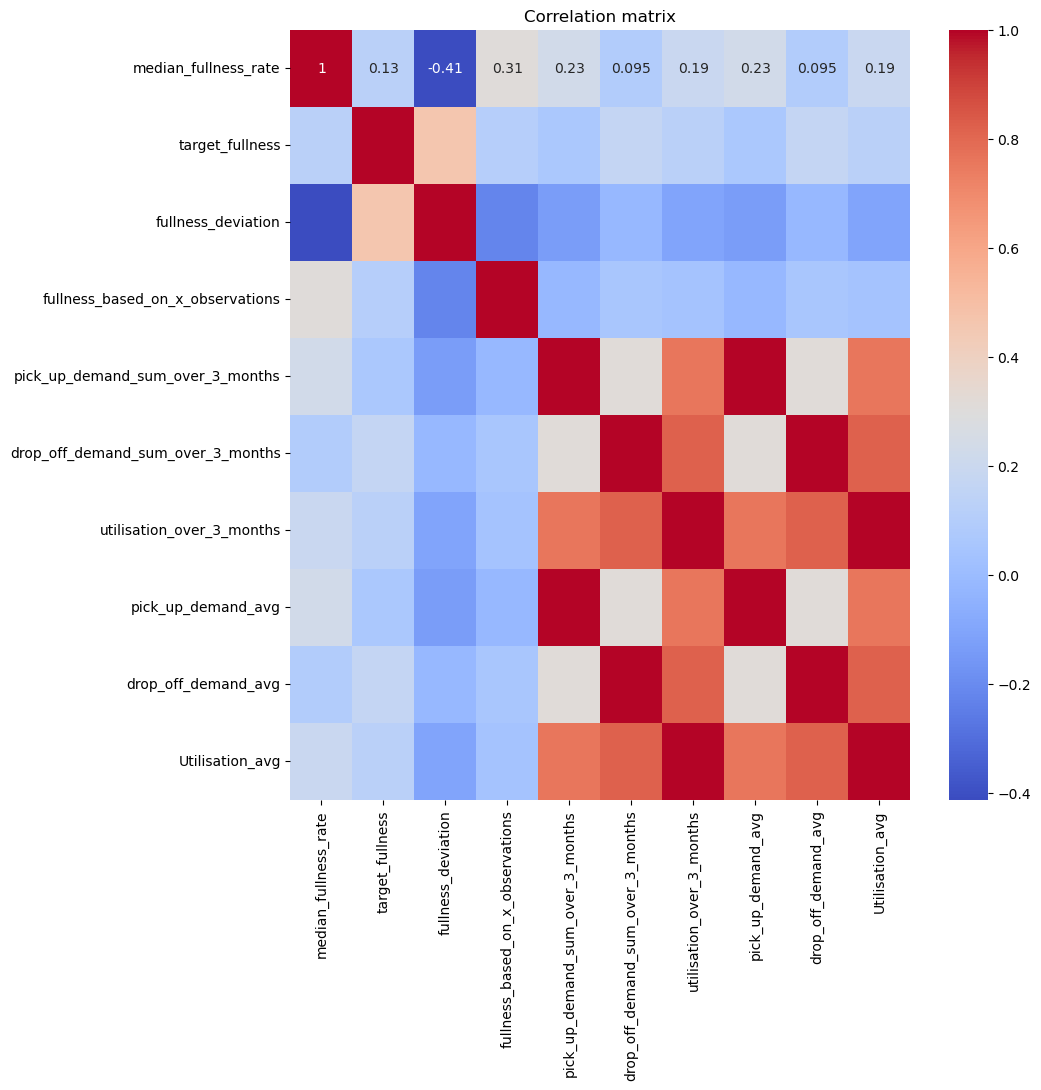

In [88]:
# plot the correlation matrix
import seaborn as sns

working_df = final_data_set_central_london.copy()
working_df = working_df.drop(columns=['station', 'hour'])


corr = working_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()
